In [1]:
cd ..

/home/hantoine/Documents/Cours/Concordia/2019-Winter/SOEN_691_Big_Data_Analytics/project/accident-prediction-montreal


In [2]:
import sys
sys.path.insert(0, '/home/hantoine/concordia/bigdata/project/spark/python')

In [3]:
from utils import init_spark
spark = init_spark()
spark.version

Spark Session created
Parameters:
	spark.network.timeout: 300s
	spark.executor.id: driver
	spark.master: local[6]
	spark.app.name: Accident prediction
	spark.cleaner.periodicGC.interval: 5min
	spark.serializer: org.apache.spark.serializer.KryoSerializer
	spark.app.id: local-1555288760904
	spark.driver.memory: 3g
	spark.driver.port: 37763
	spark.rdd.compress: True
	spark.driver.host: laptop-hantoine
	spark.serializer.objectStreamReset: 100
	spark.submit.pyFiles: 
	spark.submit.deployMode: client
	spark.ui.showConsoleProgress: true


'3.0.0-SNAPSHOT'

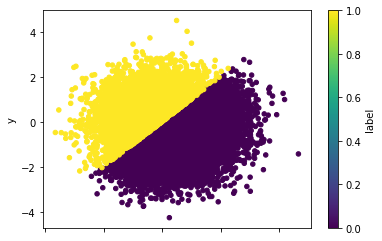

In [71]:
from pyspark.sql.functions import *
df = spark.createDataFrame(zip(range(50000),))
df = df.select(randn().alias('x'), randn().alias('y'))
df = df.withColumn('label', when(col('x') < col('y'), lit(1.0)).otherwise(lit(0.0)))
df = df.filter(col('label') == 0).union(df.filter(col('label') == 1.0).sample(1/5))
df.toPandas().plot.scatter(x='x', y="y", c="label", colormap="viridis")

In [72]:
from pyspark.ml.classification import RandomForestClassifier
from class_weighter import ClassWeighter
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline


(train_set, test_set) = df.randomSplit([0.7, 0.3])

In [73]:
va = VectorAssembler(inputCols=['x', 'y'], outputCol="features")
rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            cacheNodeIds=True,
                            maxDepth=30,
                            weightCol='weight')
cw_weighted = ClassWeighter().setClassWeight([1/5, 1.0])
cw = ClassWeighter().setClassWeight([1.0, 1.0])
pipeline_weighted = Pipeline().setStages([va, cw_weighted, rf])
pipeline = Pipeline().setStages([va, cw, rf])
model = pipeline.fit(train_set)
model_weighted = pipeline_weighted.fit(train_set)
pred = model.transform(test_set)
pred_weighted = model_weighted.transform(test_set)

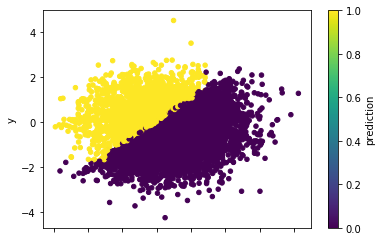

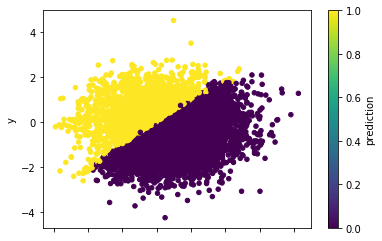

In [74]:
pred.toPandas().plot.scatter(x='x', y="y", c="prediction", colormap="viridis")
pred_weighted.toPandas().plot.scatter(x='x', y="y", c="prediction", colormap="viridis")

In [75]:
fn = pred.filter((col('prediction') == 0.0) & (col('label') == 1.0)).count()
fn_weighted = pred_weighted.filter((col('prediction') == 0.0) & (col('label') == 1.0)).count()
print(fn, fn_weighted)

43 10


In [76]:
fp = pred.filter((col('prediction') == 1.0) & (col('label') == 0.0)).count()
fp_weighted = pred_weighted.filter((col('prediction') == 1.0) & (col('label') == 0.0)).count()
print(fp, fp_weighted)

26 130


In [77]:
from evaluate import evaluate_binary_classifier
evaluate_binary_classifier(pred)
evaluate_binary_classifier(pred_weighted)

Area Under PR = 0.9933614787059873
F1 score = 0.9923649363022257
Area Under PR = 0.9974330709095401
F1 score = 0.9847802360438612


(0.9974330709095401, 0.9847802360438612)